**Please ensure to go through `README.md` before getting started**

# Introduction to Autogen

Autogen is an open-source multi-agent orchestration framework by Microsoft that enables the creation of intelligent, collaborative AI workflows using Large Language Models (LLMs). It supports advanced use cases such as dynamic tool usage, real-time streaming, structured responses, and customizable memory/context strategies.

This notebook, **Introduction to Autogen**, is designed to give you hands-on exposure to the building blocks of agentic applications. You'll explore:

-  Defining and running `AssistantAgent` with tools and streaming
-  Sending `TextMessage`, `MultiModalMessage`, and custom structured messages
-  Tool use via async functions and reflection
-  Streaming tokens and message-level control
-  Limiting model context using buffered strategies
-  Persisting and restoring agent state
-  Building custom agents for retries and data transformations
-  Using agent teams and selectors (e.g., for dynamic data pipelines)

## Install dependencies

In [1]:
%pip install -qU autogen "autogen-agentchat" "autogen-ext[openai,azure]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.0/234.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.3/213.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.9/307.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.4/331.4 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.3/191.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Initialising Azure OpenAI client to invoke LLM

In [2]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from autogen_core.models import UserMessage

In [3]:
az_model_client = AzureOpenAIChatCompletionClient(
    azure_deployment_name="gpt-4.1-mini",
    model="gpt-4.1-mini",
    api_version="2025-01-01-preview",
    azure_endpoint="",
    api_key="", # For key-based authentication.

)

# result = await az_model_client.create([UserMessage(content="What is the capital of France?", source="user")])
# print(result)
# await az_model_client.close()

## Logging

AutoGen uses standard Python logging module to log events like model calls and responses. The logger name is autogen_core.EVENT_LOGGER_NAME, and the event type is LLMCall.

In [4]:
import logging

from autogen_core import EVENT_LOGGER_NAME

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(EVENT_LOGGER_NAME)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)


## Message System

AgentChat uses messages to enable communication between agents and also handle internal actions. Messages fall into two major categories:

Agent-Agent Messages: For inter-agent communication (e.g., text, image)

Internal Events: For internal agent actions like tool invocation and result processing



### Agent-Agent Messages

Agent-to-agent messages inherit from BaseChatMessage. The two most common types:

- TextMessage – sends plain text

- MultiModalMessage – combines text with media like images

In [5]:
# Text message
from autogen_agentchat.messages import TextMessage

# Create a text message from a user
text_message = TextMessage(content="Hello, world!", source="User")
text_message


TextMessage(id='9af6c9fe-313d-4767-882e-67573061b5c8', source='User', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 12, 11, 9, 7, 46, 360813, tzinfo=datetime.timezone.utc), content='Hello, world!', type='TextMessage')

### Multi Modal messages


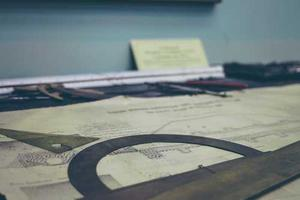

In [6]:
from io import BytesIO
import requests
from PIL import Image
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image as AGImage

# Load an image from the web
pil_image = Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = AGImage(pil_image)

# Create a multimodal message with text and image
multi_modal_message = MultiModalMessage(
    content=["Can you describe the content of this image?", img],
    source="User"
)
img
# multi_modal_message


### Subclasses in messages

Why and when to subclass?

AutoGen ships two abstract bases—BaseChatMessage for messages exchanged between agents, and BaseAgentEvent for messages that represent internal actions such as tool calls or status updates. Subclassing them lets you attach structured data, override renderers, or surface extra metadata for UI layers

Imports & helper models

In [7]:
from __future__ import annotations

from typing import Any, Dict
from pydantic import BaseModel
from autogen_agentchat.messages import (
    BaseChatMessage,
    BaseAgentEvent,
)
from autogen_core.models import UserMessage  # needed for .to_model_message()


### Custom Chat Message (JsonMessage)

The three abstract methods are required by `BaseChatMessage`

In [8]:
class JsonMessage(BaseChatMessage):
    """
    A message whose `content` is a JSON-serialisable dict.
    Useful for passing structured payloads (e.g. API specs) between agents.
    """

    content: Dict[str, Any]

    # ---- required text renderers ----
    def to_text(self) -> str:
        return f"[JSON] {self.content}"

    def to_model_text(self) -> str:
        # Large-language models need a string; serialise compactly.
        return str(self.content)

    def to_model_message(self) -> UserMessage:
        # Wrap for the model client; UserMessage is the standard wrapper.
        return UserMessage(content=self.to_model_text(), source=self.source)


### Custom Internal Event (`AlertEvent`)

Inheriting from BaseAgentEvent tags this as an internal signal, not for LLM consumption

In [9]:
class AlertEvent(BaseAgentEvent):
    """
    An internal event signalling that an agent raised a critical alert.
    """

    level: str  # e.g. "INFO", "WARN", "CRITICAL"
    details: str

    def to_text(self) -> str:
        # How the event should appear in logs or a dashboard
        return f"[{self.level}] {self.details}"


### Minimal Demo with an AssistantAgent

This cell demonstrates:

- Creating and sending a structured inter-agent message (JsonMessage) so the LLM receives a well-formed JSON string.

- Logging an internal agent event (AlertEvent) that would be forwarded to a UI or orchestrator layer.

- Smooth asynchronous execution inside a notebook (via nest_asyncio)


In [10]:
from autogen_core import CancellationToken
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
import nest_asyncio, asyncio

nest_asyncio.apply()

# Define a dummy weather tool
async def get_weather(city: str) -> str:
    return f"Dummy weather in {city}."

# Instantiate the agent
agent = AssistantAgent(
    name="tester",
    model_client=az_model_client,
    tools=[get_weather],
    system_message="Tester",
    reflect_on_tool_use=True,
    model_client_stream=True,
)

async def run_demo():
    # Create a cancellation token
    token = CancellationToken()
    # Send a message correctly with the token
    response = await agent.on_messages(
        [TextMessage(content="Hi, what's the weather in Paris?", source="User")],
        cancellation_token=token  #  required
    )
    print("Agent replied:", response.chat_message.content)


await run_demo()


{"type": "LLMStreamStart", "messages": [{"content": "Tester", "role": "system"}, {"role": "user", "name": "User", "content": "Hi, what's the weather in Paris?"}], "agent_id": null}
INFO:autogen_core.events:{"type": "LLMStreamStart", "messages": [{"content": "Tester", "role": "system"}, {"role": "user", "name": "User", "content": "Hi, what's the weather in Paris?"}], "agent_id": null}
{"type": "LLMStreamEnd", "response": {"finish_reason": "function_calls", "content": [{"id": "call_NaHCCmWpolzYrKMFuUrOw5x5", "arguments": "{\"city\":\"Paris\"}", "name": "get_weather"}], "usage": {"prompt_tokens": 0, "completion_tokens": 0}, "cached": false, "logprobs": null, "thought": null}, "prompt_tokens": 0, "completion_tokens": 0, "agent_id": null}
INFO:autogen_core.events:{"type": "LLMStreamEnd", "response": {"finish_reason": "function_calls", "content": [{"id": "call_NaHCCmWpolzYrKMFuUrOw5x5", "arguments": "{\"city\":\"Paris\"}", "name": "get_weather"}], "usage": {"prompt_tokens": 0, "completion_to

Agent replied: The weather in Paris is currently clear with mild temperatures. If you need more specific details or the forecast, please let me know!


With these patterns, you can build rich, structured interactions and telemetry in your AutoGen-based agentic systems.

## Understanding agents


AutoGen AgentChat includes a collection of built-in Agents—distinct AI personalities designed to handle messages in different ways. Despite their varied capabilities, they all share the following core properties and methods:

`name`: A unique identifier for the agent.

`description`: A textual summary explaining the agent’s purpose.

`run(task)`: Executes the agent on either a string task or a list of messages, returning a TaskResult. Agents preserve internal state, so each call should pass only new messages, not the full chat history.

`run_stream(task)`: Similar to run(), but returns a stream of messages (BaseChatMessage or BaseAgentEvent), ending with the TaskResult.

These agents internally rely on the message classes from autogen_agentchat.messages.


In [11]:
# Define a simple function tool that the agent can use.
async def get_weather(city: str) -> str:
    """Get the weather for a given city."""
    return f"The weather in {city} is 73 degrees and Sunny."

In [12]:
# Define an AssistantAgent with the model, tool, system message, and reflection enabled.
agent = AssistantAgent(
    name="weather_agent",
    model_client=az_model_client,
    tools=[get_weather],
    system_message="You are a helpful assistant.",
    reflect_on_tool_use=True,
    model_client_stream=True,  # Enable streaming tokens from the model client.
)


Getting responses
We can use the `run()` method to get the agent run on a given task.
When you call run(), the method returns a TaskResult object. This object includes a messages attribute—a list that captures the agent’s entire “chain of thought” along with its final reply.

Important: Each time you call run(), the agent updates its internal history by appending those messages. As a result:

Calling run() accumulates conversation state—don’t resend the full message history on each call.

You can invoke run() with no new task: this prompts the agent to continue based on its current context.

In short:

run() → TaskResult → messages list shows reasoning steps + final answer.
And calling run() mutates the agent’s memory, so treat it as stateful.

In [13]:
# Run the agent and stream the messages to the console.
async def main() -> None:
    await Console(agent.run_stream(task="What is the weather in New York?"))

await main()

---------- TextMessage (user) ----------
What is the weather in New York?


{"type": "LLMStreamStart", "messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"role": "user", "name": "user", "content": "What is the weather in New York?"}], "agent_id": null}
INFO:autogen_core.events:{"type": "LLMStreamStart", "messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"role": "user", "name": "user", "content": "What is the weather in New York?"}], "agent_id": null}
{"type": "LLMStreamEnd", "response": {"finish_reason": "function_calls", "content": [{"id": "call_YdVoHvkqo3D8lw14jzHo5GBz", "arguments": "{\"city\":\"New York\"}", "name": "get_weather"}], "usage": {"prompt_tokens": 0, "completion_tokens": 0}, "cached": false, "logprobs": null, "thought": null}, "prompt_tokens": 0, "completion_tokens": 0, "agent_id": null}
INFO:autogen_core.events:{"type": "LLMStreamEnd", "response": {"finish_reason": "function_calls", "content": [{"id": "call_YdVoHvkqo3D8lw14jzHo5GBz", "arguments": "{\"city\":\"New York\"}", "name": "get_weathe

---------- ToolCallRequestEvent (weather_agent) ----------
[FunctionCall(id='call_YdVoHvkqo3D8lw14jzHo5GBz', arguments='{"city":"New York"}', name='get_weather')]


{"type": "ToolCall", "tool_name": "get_weather", "arguments": {"city": "New York"}, "result": "The weather in New York is 73 degrees and Sunny.", "agent_id": null}
INFO:autogen_core.events:{"type": "ToolCall", "tool_name": "get_weather", "arguments": {"city": "New York"}, "result": "The weather in New York is 73 degrees and Sunny.", "agent_id": null}


---------- ToolCallExecutionEvent (weather_agent) ----------
[FunctionExecutionResult(content='The weather in New York is 73 degrees and Sunny.', name='get_weather', call_id='call_YdVoHvkqo3D8lw14jzHo5GBz', is_error=False)]


{"type": "LLMStreamStart", "messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"role": "user", "name": "user", "content": "What is the weather in New York?"}, {"role": "assistant", "tool_calls": [{"id": "call_YdVoHvkqo3D8lw14jzHo5GBz", "function": {"arguments": "{\"city\":\"New York\"}", "name": "get_weather"}, "type": "function"}], "content": null}, {"content": "The weather in New York is 73 degrees and Sunny.", "role": "tool", "tool_call_id": "call_YdVoHvkqo3D8lw14jzHo5GBz"}], "agent_id": null}
INFO:autogen_core.events:{"type": "LLMStreamStart", "messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"role": "user", "name": "user", "content": "What is the weather in New York?"}, {"role": "assistant", "tool_calls": [{"id": "call_YdVoHvkqo3D8lw14jzHo5GBz", "function": {"arguments": "{\"city\":\"New York\"}", "name": "get_weather"}, "type": "function"}], "content": null}, {"content": "The weather in New York is 73 degrees and Sunny.", "role"

---------- ModelClientStreamingChunkEvent (weather_agent) ----------
The weather in New York is currently 73 degrees and sunny. Is there anything else you would like to know?

{"type": "LLMStreamEnd", "response": {"finish_reason": "stop", "content": "The weather in New York is currently 73 degrees and sunny. Is there anything else you would like to know?", "usage": {"prompt_tokens": 0, "completion_tokens": 0}, "cached": false, "logprobs": null, "thought": null}, "prompt_tokens": 0, "completion_tokens": 0, "agent_id": null}
INFO:autogen_core.events:{"type": "LLMStreamEnd", "response": {"finish_reason": "stop", "content": "The weather in New York is currently 73 degrees and sunny. Is there anything else you would like to know?", "usage": {"prompt_tokens": 0, "completion_tokens": 0}, "cached": false, "logprobs": null, "thought": null}, "prompt_tokens": 0, "completion_tokens": 0, "agent_id": null}


### Multi-Modal Input
The AssistantAgent can handle multi-modal input by providing the input as a MultiModalMessage.

{"type": "LLMStreamStart", "messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"role": "user", "name": "user", "content": [{"type": "text", "text": "Can you describe the content of this image?"}, {"type": "image_url", "image_url": {"url": "", "detail": "auto"}}]}], "agent_id": null}
INFO:autogen_core.events:{"type": "LLMStreamStart", "messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"role": "user", "name": "user", "content": [{"type": "text", "text": "Can you describe the content of this image?"}, {"type": "image_url", "image_url": {"url": "", "detail": "auto"}}]}], "agent_id": null}
{"type": "LLMStreamEnd", "response": {"finish_reason": "stop", "content": "The image shows a workspace setup on a wooden surface. There is an open laptop displaying what appears to be a design or presentation software with various thumbnails and a blue background on the screen. To the right of the laptop, there is an open notebook with handwritten notes a
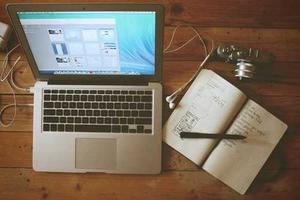
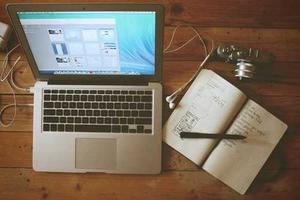

The image shows a workspace setup on a wooden surface. There is an open laptop displaying what appears to be a design or presentation software with various thumbnails and a blue background on the screen. To the right of the laptop, there is an open notebook with handwritten notes and some drawings or diagrams. A black pen is resting diagonally across the notebook. In addition, there are white earbuds and a camera with a strap placed on the desk near the notebook. The scene suggests someone is working on a creative project or studying.


In [14]:
from io import BytesIO

import PIL
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import Image

# Create a multi-modal message with random image and text.
pil_image = PIL.Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = Image(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="user")
img

# Define an AssistantAgent with the model, tool, system message, and reflection enabled.
multimodal_agent = AssistantAgent(
    name="multimodal_agent",
    model_client=az_model_client,
    system_message="You are a helpful assistant.",
    reflect_on_tool_use=True,
    model_client_stream=True,  # Enable streaming tokens from the model client.
)

# Use asyncio.run(...) when running in a script.
result = await multimodal_agent.run(task=multi_modal_message)
print(result.messages[-1].content)  # type: ignore


### Streaming Messages

The `run_stream()` method allows you to stream the agent’s messages as they are generated—step by step—without waiting for the entire response to complete. This includes text outputs, tool invocation events, and tool responses.

It returns an **asynchronous generator** that yields each message in real time, with a `TaskResult` provided as the final item in the stream.

By examining these streamed messages, you can clearly see how the assistant agent decides to use a tool (like `web_search`), retrieves information, and then constructs its final response based on that data. You can also use the `Console` to display these messages live for debugging or visualization.


In [15]:
async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream.
    # async for message in agent.run_stream(task="What is Azure AI Architect"):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.run_stream(task="What is Azure AI Architect"),
        output_stats=True,  # Enable stats printing.
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()


---------- TextMessage (user) ----------
What is Azure AI Architect


{"type": "LLMStreamStart", "messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"role": "user", "name": "user", "content": "What is the weather in New York?"}, {"role": "assistant", "tool_calls": [{"id": "call_YdVoHvkqo3D8lw14jzHo5GBz", "function": {"arguments": "{\"city\":\"New York\"}", "name": "get_weather"}, "type": "function"}], "content": null}, {"content": "The weather in New York is 73 degrees and Sunny.", "role": "tool", "tool_call_id": "call_YdVoHvkqo3D8lw14jzHo5GBz"}, {"role": "assistant", "content": "The weather in New York is currently 73 degrees and sunny. Is there anything else you would like to know?"}, {"role": "user", "name": "user", "content": "What is Azure AI Architect"}], "agent_id": null}
INFO:autogen_core.events:{"type": "LLMStreamStart", "messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"role": "user", "name": "user", "content": "What is the weather in New York?"}, {"role": "assistant", "tool_calls": [{"id": "c

---------- ModelClientStreamingChunkEvent (weather_agent) ----------
An Azure AI Architect is a professional who designs and implements artificial intelligence (AI) solutions using Microsoft Azure's AI services and tools. This role typically involves leveraging Azure's cognitive services, machine learning, and AI frameworks to build intelligent applications that meet business needs. Responsibilities of an Azure AI Architect may include:

1. Designing AI solutions that integrate with various Azure services.
2. Selecting appropriate Azure AI and machine learning tools for specific business problems.
3. Architecting scalable and secure AI systems on the Azure cloud platform.
4. Collaborating with developers, data scientists, and stakeholders to deliver AI-driven features.
5. Ensuring the AI solutions comply with best practices, ethical standards, and regulatory requirements.
6. Monitoring and optimizing the performance of deployed AI models and services.

This role requires a strong under

{"type": "LLMStreamEnd", "response": {"finish_reason": "stop", "content": "An Azure AI Architect is a professional who designs and implements artificial intelligence (AI) solutions using Microsoft Azure's AI services and tools. This role typically involves leveraging Azure's cognitive services, machine learning, and AI frameworks to build intelligent applications that meet business needs. Responsibilities of an Azure AI Architect may include:\n\n1. Designing AI solutions that integrate with various Azure services.\n2. Selecting appropriate Azure AI and machine learning tools for specific business problems.\n3. Architecting scalable and secure AI systems on the Azure cloud platform.\n4. Collaborating with developers, data scientists, and stakeholders to deliver AI-driven features.\n5. Ensuring the AI solutions comply with best practices, ethical standards, and regulatory requirements.\n6. Monitoring and optimizing the performance of deployed AI models and services.\n\nThis role requires


[Prompt tokens: 0, Completion tokens: 0]
---------- Summary ----------
Number of messages: 2
Finish reason: None
Total prompt tokens: 0
Total completion tokens: 0
Duration: 3.45 seconds


## Using tools with agents

### Why Add Tools to LLMs?

Large-language models (LLMs) excel at reasoning and text generation, but they **cannot**:

* Query real-time data (APIs, DBs, web)
* Invoke business logic with side-effects (payments, email, file I/O)
* Maintain long-lived shared state

**Tool calling** (aka *function calling*) fills this gap.  
An LLM receives a catalog of tool *schemas*—JSON definitions of names, parameters, and descriptions.  
At inference time it may output a **tool-call message**, requesting the runtime to execute that tool and feed the result back into the conversation.

AutoGen AgentChat bakes this pattern into `AssistantAgent`:

* **FunctionTool** – any Python `async def` is auto-wrapped.
* **Workbench** – a *collection* of tools that share state or back-end resources.
* **Reflection** – optionally summarize raw tool output into user-friendly text.

Below we’ll wire up both a simple function tool (`web_search_func`) and a more advanced **MCP workbench** tool (remote “fetch” server).


### FunctionTool: Turning a Python Function into an Agent Tool

Any `async` Python function with type hints + docstring is **auto-converted** to a `FunctionTool`
when you pass it to `AssistantAgent.tools`.  
AutoGen also lets you construct it explicitly via `FunctionTool(...)` if you need the schema.

*The LLM sees the schema only—not the implementation—so keep the description precise but concise.*


Define and inspect a function tool

In [16]:
from autogen_core.tools import FunctionTool

# 🚀 Example tool
async def web_search_func(query: str) -> str:
    """Find information on the web"""
    return "AutoGen is a programming framework for building multi-agent applications."

# Manual wrap (optional)
web_search_tool = FunctionTool(web_search_func, description="Find information on the web")

# Display the generated JSON schema
web_search_tool.schema


{'name': 'web_search_func',
 'description': 'Find information on the web',
 'parameters': {'type': 'object',
  'properties': {'query': {'description': 'query',
    'title': 'Query',
    'type': 'string'}},
  'required': ['query'],
  'additionalProperties': False},
 'strict': False}

### AssistantAgent + Reflection

`AssistantAgent` is a “kitchen-sink” agent for prototyping.  
Key parameters:

| Param | Purpose |
|-------|---------|
| `model_client` | Chat-completion backend (OpenAI, Azure, etc.) |
| `tools` | List of `async` functions or `BaseTool` objects |
| `system_message` | High-level instruction shown to the LLM |
| `reflect_on_tool_use=True` | After a tool returns, the LLM is prompted to summarize the raw output into natural language. |


In [17]:
nest_asyncio.apply()


assistant = AssistantAgent(
    name="assistant",
    model_client=az_model_client,
    tools=[web_search_func],        # raw function is fine
    system_message="Use tools to solve tasks.",
    reflect_on_tool_use=True,
)

async def demo_stream():
    await Console(assistant.run_stream(task="What is AutoGen? Please search."))
    # await az_model_client.close()

await demo_stream()


---------- TextMessage (user) ----------
What is AutoGen? Please search.


{"tools": [{"type": "function", "function": {"name": "web_search_func", "description": "Find information on the web", "parameters": {"type": "object", "properties": {"query": {"description": "query", "title": "Query", "type": "string"}}, "required": ["query"], "additionalProperties": false}, "strict": false}}], "type": "LLMCall", "messages": [{"content": "Use tools to solve tasks.", "role": "system"}, {"role": "user", "name": "user", "content": "What is AutoGen? Please search."}], "response": {"id": "chatcmpl-ClWwR4JYFJdbLeYZWOfMV4bepdDpQ", "choices": [{"finish_reason": "tool_calls", "index": 0, "logprobs": null, "message": {"content": null, "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": [{"id": "call_jAeFRQC7AOKoMVuzShDvxgCu", "function": {"arguments": "{\"query\":\"AutoGen\"}", "name": "web_search_func"}, "type": "function"}]}, "content_filter_results": {}}], "created": 1765444079, "model": "gpt-4.1-mini-2025-04-14", "obje

---------- ToolCallRequestEvent (assistant) ----------
[FunctionCall(id='call_jAeFRQC7AOKoMVuzShDvxgCu', arguments='{"query":"AutoGen"}', name='web_search_func')]


{"type": "ToolCall", "tool_name": "web_search_func", "arguments": {"query": "AutoGen"}, "result": "AutoGen is a programming framework for building multi-agent applications.", "agent_id": null}
INFO:autogen_core.events:{"type": "ToolCall", "tool_name": "web_search_func", "arguments": {"query": "AutoGen"}, "result": "AutoGen is a programming framework for building multi-agent applications.", "agent_id": null}


---------- ToolCallExecutionEvent (assistant) ----------
[FunctionExecutionResult(content='AutoGen is a programming framework for building multi-agent applications.', name='web_search_func', call_id='call_jAeFRQC7AOKoMVuzShDvxgCu', is_error=False)]


{"tools": [], "type": "LLMCall", "messages": [{"content": "Use tools to solve tasks.", "role": "system"}, {"role": "user", "name": "user", "content": "What is AutoGen? Please search."}, {"role": "assistant", "tool_calls": [{"id": "call_jAeFRQC7AOKoMVuzShDvxgCu", "function": {"arguments": "{\"query\":\"AutoGen\"}", "name": "web_search_func"}, "type": "function"}], "content": null}, {"content": "AutoGen is a programming framework for building multi-agent applications.", "role": "tool", "tool_call_id": "call_jAeFRQC7AOKoMVuzShDvxgCu"}], "response": {"id": "chatcmpl-ClWwRWUv4uQ6tXrS3x5MuiHqbwICE", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "AutoGen is a programming framework designed for building multi-agent applications, enabling the creation and management of systems where multiple agents can interact and operate collaboratively. If you need more detailed information or specific aspects of AutoGen, please let me know!", "refusal": null, "ro

---------- TextMessage (assistant) ----------
AutoGen is a programming framework designed for building multi-agent applications, enabling the creation and management of systems where multiple agents can interact and operate collaboratively. If you need more detailed information or specific aspects of AutoGen, please let me know!


### Parallel Tool Calls

Some model backends (OpenAI / Azure) can propose **multiple** tool calls in a single response.  
`AssistantAgent` executes them **concurrently** by default for speed.

Disable if:
* Tools modify shared state or have conflicting side-effects.
* You need deterministic ordering across model vendors.

Set `parallel_tool_calls=False` on the model client.


## Structured Output in AutoGen

* **Goal:** Receive an agent reply as a *validated* Python object, not free-form text.
* **How:**  
  1. Define a `pydantic.BaseModel` that describes the response schema.  
  2. Pass that class to `AssistantAgent(..., output_content_type=YourModel)`.
* **Result:**  
  * The agent replies with a `StructuredMessage` whose `.content` **is** an instance of `YourModel`.  
  * AutoGen validates the JSON → dataclass conversion for you.
* **Chain-of-Thought Friendly:** The schema can contain a `thoughts` field to surface the LLM’s reasoning while keeping the final answer separate.
* **Tool Reflection:** Setting `output_content_type` implicitly enables `reflect_on_tool_use=True`.  
  Disable if unwanted: `AssistantAgent(..., reflect_on_tool_use=False)`.


In [18]:
%pip install pydantic --quiet


Define the Pydantic Schema

In [19]:
from typing import Literal
from pydantic import BaseModel

class AgentResponse(BaseModel):
    thoughts: str
    response: Literal["happy", "sad", "neutral"]


Instantiate the agent

In [20]:
from autogen_agentchat.messages import StructuredMessage
agent = AssistantAgent(
    name="sentiment_assistant",
    model_client=az_model_client,
    system_message="Categorize the input as happy, sad, or neutral following the JSON format.",
    output_content_type=AgentResponse,  # 🚀 structured output
)


Run and validate

In [21]:
import nest_asyncio, asyncio
nest_asyncio.apply()

async def demo():
    result = await Console(agent.run_stream(task="I am happy."))
    # Last message should be StructuredMessage -> AgentResponse
    last_msg = result.messages[-1]
    assert isinstance(last_msg, StructuredMessage)
    assert isinstance(last_msg.content, AgentResponse)

    print("💡 Thoughts:", last_msg.content.thoughts)
    print("🎯 Response:", last_msg.content.response)

await demo()


---------- TextMessage (user) ----------
I am happy.


{"tools": [], "type": "LLMCall", "messages": [{"content": "Categorize the input as happy, sad, or neutral following the JSON format.", "role": "system"}, {"role": "user", "name": "user", "content": "I am happy."}], "response": {"id": "chatcmpl-ClWwYANyYYxnr1RYTAeLw40WSMHLL", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "{\"thoughts\":\"The user's statement explicitly expresses happiness.\",\"response\":\"happy\"}", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null, "parsed": {"thoughts": "The user's statement explicitly expresses happiness.", "response": "happy"}}, "content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {"filtered": false, "detected": false}, "self_harm": {"filtered": false, "severity": "safe"}, "sexual": {"filtered": false, "severity": "safe"}, "vi

---------- StructuredMessage[AgentResponse] (sentiment_assistant) ----------
{"thoughts":"The user's statement explicitly expresses happiness.","response":"happy"}
💡 Thoughts: The user's statement explicitly expresses happiness.
🎯 Response: happy


## Streaming Tokens in AutoGen

When `model_client_stream=True` is enabled on the agent, the underlying model client (like OpenAI) can stream token chunks *as they are generated*.  

During `run_stream()`, the agent yields:
- A `TextMessage` from the user
- Multiple `ModelClientStreamingChunkEvent` messages as each token arrives
- A final `TextMessage` that contains the full concatenated response

> This is useful for building real-time UIs, progress updates, or just faster feedback loops.


In [22]:

from autogen_agentchat.messages import ModelClientStreamingChunkEvent, TextMessage


In [23]:
# Enable model_client_stream
streaming_agent = AssistantAgent(
    name="streaming_assistant",
    model_client=az_model_client,
    system_message="You are a helpful assistant.",
    model_client_stream=True  #  enables streaming token chunks
)


Stream and print each token/message

In [24]:
async def stream_task():
    print("\nAgent stream output:\n")

    async for msg in streaming_agent.run_stream(task="Name two cities in South America"):
        if hasattr(msg, "type") and hasattr(msg, "content"):
            print(f"{msg.type}: {msg.content}")
        elif isinstance(msg, TextMessage):
            print(f"TextMessage (no type): {msg.content}")
        else:
            print(f"[TaskResult] Task completed with {len(msg.messages)} messages.")

    # await model_client.close()


await stream_task()



Agent stream output:

TextMessage: Name two cities in South America


{"type": "LLMStreamStart", "messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"role": "user", "name": "user", "content": "Name two cities in South America"}], "agent_id": null}
INFO:autogen_core.events:{"type": "LLMStreamStart", "messages": [{"content": "You are a helpful assistant.", "role": "system"}, {"role": "user", "name": "user", "content": "Name two cities in South America"}], "agent_id": null}
{"type": "LLMStreamEnd", "response": {"finish_reason": "stop", "content": "Two cities in South America are Buenos Aires (Argentina) and S\u00e3o Paulo (Brazil).", "usage": {"prompt_tokens": 0, "completion_tokens": 0}, "cached": false, "logprobs": null, "thought": null}, "prompt_tokens": 0, "completion_tokens": 0, "agent_id": null}
INFO:autogen_core.events:{"type": "LLMStreamEnd", "response": {"finish_reason": "stop", "content": "Two cities in South America are Buenos Aires (Argentina) and S\u00e3o Paulo (Brazil).", "usage": {"prompt_tokens": 0, "completion_tokens

ModelClientStreamingChunkEvent: Two
ModelClientStreamingChunkEvent:  cities
ModelClientStreamingChunkEvent:  in
ModelClientStreamingChunkEvent:  South
ModelClientStreamingChunkEvent:  America
ModelClientStreamingChunkEvent:  are
ModelClientStreamingChunkEvent:  Buenos
ModelClientStreamingChunkEvent:  Aires
ModelClientStreamingChunkEvent:  (
ModelClientStreamingChunkEvent: Argentina
ModelClientStreamingChunkEvent: )
ModelClientStreamingChunkEvent:  and
ModelClientStreamingChunkEvent:  São
ModelClientStreamingChunkEvent:  Paulo
ModelClientStreamingChunkEvent:  (
ModelClientStreamingChunkEvent: Brazil
ModelClientStreamingChunkEvent: ).
TextMessage: Two cities in South America are Buenos Aires (Argentina) and São Paulo (Brazil).
[TaskResult] Task completed with 2 messages.


## Controlling the Model's Context Window



By default, `AssistantAgent` uses **UnboundedChatCompletionContext**, which sends the *entire* chat history to the model.

This can:
- Improve long-term memory
- But also exceed token limits or increase latency

### Solution: Use Custom Model Contexts
You can limit what gets passed to the model using `model_context=...`

Available options:
| Context Type | Purpose |
|--------------|---------|
| `UnboundedChatCompletionContext` | (Default) Sends full conversation history |
| `BufferedChatCompletionContext(n)` | Keeps only the **last `n` messages** |
| `TokenLimitedChatCompletionContext(max_tokens)` | Keeps as many recent messages as possible within `max_tokens` |


Setting up the agent with `BufferedChatCompletionContext`

In [25]:

from autogen_core.model_context import BufferedChatCompletionContext
# Example async tool (optional)
async def web_search(query: str) -> str:
    return f"Fake result for '{query}'"


# Agent that only uses the last 5 messages from history
agent = AssistantAgent(
    name="context_limited_agent",
    model_client=az_model_client,
    tools=[web_search],
    system_message="Use tools and respond concisely.",
    model_context=BufferedChatCompletionContext(buffer_size=5),
)


Preview in action

In [26]:
from autogen_agentchat.ui import Console
import nest_asyncio, asyncio
nest_asyncio.apply()

# Run the agent and demonstrate behavior
async def run_context_demo():
    await Console(agent.run_stream(task="What are some cities in South America?"))
    # await model_client.close()

await run_context_demo()


---------- TextMessage (user) ----------
What are some cities in South America?


{"tools": [{"type": "function", "function": {"name": "web_search", "description": "", "parameters": {"type": "object", "properties": {"query": {"description": "query", "title": "Query", "type": "string"}}, "required": ["query"], "additionalProperties": false}, "strict": false}}], "type": "LLMCall", "messages": [{"content": "Use tools and respond concisely.", "role": "system"}, {"role": "user", "name": "user", "content": "What are some cities in South America?"}], "response": {"id": "chatcmpl-ClWwa6et1JHBsRQ3Uz1GzK8P3GytB", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "Some cities in South America include:\n\n1. Buenos Aires, Argentina\n2. S\u00e3o Paulo, Brazil\n3. Rio de Janeiro, Brazil\n4. Lima, Peru\n5. Bogot\u00e1, Colombia\n6. Santiago, Chile\n7. Caracas, Venezuela\n8. Quito, Ecuador\n9. Montevideo, Uruguay\n10. La Paz, Bolivia\n\nWould you like information about cities from specific countries or more cities?", "refusal": null, "role":

---------- TextMessage (context_limited_agent) ----------
Some cities in South America include:

1. Buenos Aires, Argentina
2. São Paulo, Brazil
3. Rio de Janeiro, Brazil
4. Lima, Peru
5. Bogotá, Colombia
6. Santiago, Chile
7. Caracas, Venezuela
8. Quito, Ecuador
9. Montevideo, Uruguay
10. La Paz, Bolivia

Would you like information about cities from specific countries or more cities?


## Saving and Loading Agent State in AutoGen



In multi-agent applications or stateless web apps, it's crucial to **persist state** so that agents can:

- Resume conversations
- Maintain memory across sessions
- Handle stateless request-response interactions

AutoGen allows saving/loading:
- Agent state (e.g. chat history)
- Team state (e.g. messages, member roles, termination conditions)

States are returned as **serializable dictionaries**, which can be saved to JSON files or databases.


Create and run agent, then save state

In [27]:
import json
nest_asyncio.apply()

assistant_agent = AssistantAgent(
    name="assistant_agent",
    system_message="You are a helpful assistant",
    model_client=az_model_client,
)

# Run agent on a task
response = await assistant_agent.on_messages(
    [TextMessage(content="Write a 3 line poem on lake tangayika", source="user")],
    cancellation_token=CancellationToken()
)

print(response.chat_message.content)

# Save agent state to memory
agent_state = await assistant_agent.save_state()
print(agent_state)

# Optional: persist to file
with open("agent_state.json", "w") as f:
    json.dump(agent_state, f)


{"tools": [], "type": "LLMCall", "messages": [{"content": "You are a helpful assistant", "role": "system"}, {"role": "user", "name": "user", "content": "Write a 3 line poem on lake tangayika"}], "response": {"id": "chatcmpl-ClWwcTGSrweIjgfd8HgzYQi2pOWRw", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "Lake Tanganyika, deep and grand,  \nStretching far across the land,  \nA treasure carved by nature\u2019s hand.", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}, "content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {"filtered": false, "detected": false}, "self_harm": {"filtered": false, "severity": "safe"}, "sexual": {"filtered": false, "severity": "safe"}, "violence": {"filtered": false, "severity": "safe"}}}], "created": 1765444090, "model": "gpt-4.1-mini-2025-

Lake Tanganyika, deep and grand,  
Stretching far across the land,  
A treasure carved by nature’s hand.
{'type': 'AssistantAgentState', 'version': '1.0.0', 'llm_context': {'messages': [{'content': 'Write a 3 line poem on lake tangayika', 'source': 'user', 'type': 'UserMessage'}, {'content': 'Lake Tanganyika, deep and grand,  \nStretching far across the land,  \nA treasure carved by nature’s hand.', 'thought': None, 'source': 'assistant_agent', 'type': 'AssistantMessage'}]}}


Load State into New Agent & Continue Conversation

In [28]:
# Load previous state from disk
with open("agent_state.json", "r") as f:
    agent_state = json.load(f)


new_agent = AssistantAgent(
    name="assistant_agent",
    system_message="You are a helpful assistant",
    model_client=az_model_client,
)

# Load saved state
await new_agent.load_state(agent_state)

# Resume conversation
response = await new_agent.on_messages(
    [TextMessage(content="What was the last line of the previous poem you wrote", source="user")],
    cancellation_token=CancellationToken()
)

print(response.chat_message.content)
# await model_client.close()


{"tools": [], "type": "LLMCall", "messages": [{"content": "You are a helpful assistant", "role": "system"}, {"role": "user", "name": "user", "content": "Write a 3 line poem on lake tangayika"}, {"role": "assistant", "content": "Lake Tanganyika, deep and grand,  \nStretching far across the land,  \nA treasure carved by nature\u2019s hand."}, {"role": "user", "name": "user", "content": "What was the last line of the previous poem you wrote"}], "response": {"id": "chatcmpl-ClWwdaI0ezG1FFPL1OFZQu8x7yn7t", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "The last line of the previous poem I wrote was:  \n\"A treasure carved by nature\u2019s hand.\"", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}, "content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {"filtered": fals

The last line of the previous poem I wrote was:  
"A treasure carved by nature’s hand."


## Building and Using Custom Agents

AutoGen AgentChat supports the creation of custom agents to suit advanced use cases or specialized behaviors that go beyond the standard `AssistantAgent`. All agents must inherit from `BaseChatAgent` and implement the following:

- `on_messages()` – defines how the agent responds to a sequence of messages.
- `on_reset()` – defines how the agent resets its internal state.
- `produced_message_types` – specifies the types of messages the agent can emit.
- Optionally: `on_messages_stream()` for streaming responses token-by-token or message-by-message.

Custom agents are useful when you:
- Want full control over agent behavior.
- Need to use a custom model.
- Are working with structured environments like teams or selectors.

### Retry Feedback Announcer

**Use case:** Agent streams each remaining retry step (e.g., for upload or login attempts).

**Concept:** Demonstrates streaming retry countdowns using `on_messages_stream()`.

In [29]:
from typing import AsyncGenerator, List, Sequence
from autogen_agentchat.agents import BaseChatAgent
from autogen_agentchat.base import Response
from autogen_agentchat.messages import BaseAgentEvent, BaseChatMessage, TextMessage
from autogen_core import CancellationToken

class CountDownAgent(BaseChatAgent):
    def __init__(self, name: str, count: int = 3):
        super().__init__(name, "A retry announcer that streams remaining attempts.")
        self._count = count

    @property
    def produced_message_types(self) -> Sequence[type[BaseChatMessage]]:
        return (TextMessage,)

    async def on_messages(self, messages: Sequence[BaseChatMessage], cancellation_token: CancellationToken) -> Response:
        response = None
        async for message in self.on_messages_stream(messages, cancellation_token):
            if isinstance(message, Response):
                response = message
        assert response is not None
        return response

    async def on_messages_stream(
        self, messages: Sequence[BaseChatMessage], cancellation_token: CancellationToken
    ) -> AsyncGenerator[BaseAgentEvent | BaseChatMessage | Response, None]:
        inner_messages = []
        for i in range(self._count, 0, -1):
            msg = TextMessage(content=f"Retries remaining: {i}", source=self.name)
            inner_messages.append(msg)
            yield msg
        yield Response(chat_message=TextMessage(content="Final attempt reached.", source=self.name), inner_messages=inner_messages)

    async def on_reset(self, cancellation_token: CancellationToken) -> None:
        pass

# Run CountDownAgent
down_agent = CountDownAgent("retry_feedback")
async def run_down():
    async for msg in down_agent.on_messages_stream([], CancellationToken()):
        print(msg.content if hasattr(msg, "content") else msg)

await run_down()

Retries remaining: 3
Retries remaining: 2
Retries remaining: 1
Response(chat_message=TextMessage(id='f4ba65ea-3b99-49c0-a2b6-177757e8d5f9', source='retry_feedback', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 12, 11, 9, 8, 11, 615641, tzinfo=datetime.timezone.utc), content='Final attempt reached.', type='TextMessage'), inner_messages=[TextMessage(id='2599aa01-56e4-480f-a91e-5689bca7a136', source='retry_feedback', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 12, 11, 9, 8, 11, 615225, tzinfo=datetime.timezone.utc), content='Retries remaining: 3', type='TextMessage'), TextMessage(id='05529699-9c62-424e-9102-c512da097f51', source='retry_feedback', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 12, 11, 9, 8, 11, 615409, tzinfo=datetime.timezone.utc), content='Retries remaining: 2', type='TextMessage'), TextMessage(id='ddc6d3bf-fb79-487b-8aee-f770f1b37e3a', source='retry_feedback', models_usage=None, metadata={}, created_at=dat

### Data Transformation Planner

**Use case:** Simulate business logic or data transformations through multiple agent-driven steps.

**Concept:**
- Each agent applies a deterministic transformation.
- Selector chooses the next best operation in sequence.
- Demonstrates how simple steps can be composed into pipelines.

In [30]:
from typing import Callable
from autogen_agentchat.conditions import MaxMessageTermination
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

class ArithmeticAgent(BaseChatAgent):
    def __init__(self, name: str, description: str, operator_func: Callable[[int], int]):
        super().__init__(name, description=description)
        self._operator_func = operator_func
        self._message_history = []

    @property
    def produced_message_types(self) -> Sequence[type[BaseChatMessage]]:
        return (TextMessage,)

    async def on_messages(self, messages: Sequence[BaseChatMessage], cancellation_token: CancellationToken) -> Response:
        self._message_history.extend(messages)
        number = int(self._message_history[-1].content)
        result = self._operator_func(number)
        msg = TextMessage(content=str(result), source=self.name)
        self._message_history.append(msg)
        return Response(chat_message=msg)

    async def on_reset(self, cancellation_token: CancellationToken) -> None:
        pass

# Run SelectorGroupChat with Arithmetic Agents
async def run_number_agents():
    agents = [
        ArithmeticAgent("add", "Apply 10% tax", lambda x: int(x * 1.1)),
        ArithmeticAgent("discount", "Apply 5 unit discount", lambda x: x - 5),
        ArithmeticAgent("double", "Double the value", lambda x: x * 2),
        ArithmeticAgent("halve", "Cut the value in half", lambda x: x // 2),
        ArithmeticAgent("noop", "Leave as-is", lambda x: x),
    ]
    team = SelectorGroupChat(
        agents,
        model_client=az_model_client,
        termination_condition=MaxMessageTermination(10),
        allow_repeated_speaker=True,
        selector_prompt=(
            "Available roles:\n{roles}\nTheir job descriptions:\n{participants}\n"
            "Current conversation history:\n{history}\nChoose the most appropriate role."
        ),
    )
    task = [
        TextMessage(content="Apply operations to convert 20 into a reasonable retail price.", source="user"),
        TextMessage(content="20", source="user"),
    ]
    await Console(team.run_stream(task=task))

await run_number_agents()

{"payload": "{\"messages\":[{\"id\":\"f5a56af3-4f96-4a63-89b1-4c75883eaf4b\",\"source\":\"user\",\"models_usage\":null,\"metadata\":{},\"created_at\":\"2025-12-11T09:08:11.798831Z\",\"content\":\"Apply operations to convert 20 into a reasonable retail price.\",\"type\":\"TextMessage\"},{\"id\":\"e30cb156-66c9-4b99-9932-47497b35df13\",\"source\":\"user\",\"models_usage\":null,\"metadata\":{},\"created_at\":\"2025-12-11T09:08:11.798863Z\",\"content\":\"20\",\"type\":\"TextMessage\"}],\"output_task_messages\":true}", "sender": null, "receiver": "SelectorGroupChatManager_709092d4-8443-4329-b798-db7785f2019a/709092d4-8443-4329-b798-db7785f2019a", "kind": "MessageKind.DIRECT", "delivery_stage": "DeliveryStage.SEND", "type": "Message"}
INFO:autogen_core.events:{"payload": "{\"messages\":[{\"id\":\"f5a56af3-4f96-4a63-89b1-4c75883eaf4b\",\"source\":\"user\",\"models_usage\":null,\"metadata\":{},\"created_at\":\"2025-12-11T09:08:11.798831Z\",\"content\":\"Apply operations to convert 20 into a re

---------- TextMessage (user) ----------
Apply operations to convert 20 into a reasonable retail price.
---------- TextMessage (user) ----------
20
---------- TextMessage (add) ----------
22


{"tools": [], "type": "LLMCall", "messages": [{"content": "Available roles:\nadd: Apply 10% tax\ndiscount: Apply 5 unit discount\ndouble: Double the value\nhalve: Cut the value in half\nnoop: Leave as-is\nTheir job descriptions:\n['add', 'discount', 'double', 'halve', 'noop']\nCurrent conversation history:\nuser: Apply operations to convert 20 into a reasonable retail price.\n\n\nuser: 20\n\n\nadd: 22\n\n\nChoose the most appropriate role.", "role": "system"}], "response": {"id": "chatcmpl-ClWweHmBHmkZyXNXf3LjdNKpS0n6k", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "add", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}, "content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {"filtered": false, "detected": false}, "self_harm": {"filtered": false, "severity": "saf

---------- TextMessage (add) ----------
24


{"tools": [], "type": "LLMCall", "messages": [{"content": "Available roles:\nadd: Apply 10% tax\ndiscount: Apply 5 unit discount\ndouble: Double the value\nhalve: Cut the value in half\nnoop: Leave as-is\nTheir job descriptions:\n['add', 'discount', 'double', 'halve', 'noop']\nCurrent conversation history:\nuser: Apply operations to convert 20 into a reasonable retail price.\n\n\nuser: 20\n\n\nadd: 22\n\n\nadd: 24\n\n\nChoose the most appropriate role.", "role": "system"}], "response": {"id": "chatcmpl-ClWweOQoOzJGUKhmpzkOvYqMv313H", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "discount", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}, "content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {"filtered": false, "detected": false}, "self_harm": {"filtered": false

---------- TextMessage (discount) ----------
19


{"tools": [], "type": "LLMCall", "messages": [{"content": "Available roles:\nadd: Apply 10% tax\ndiscount: Apply 5 unit discount\ndouble: Double the value\nhalve: Cut the value in half\nnoop: Leave as-is\nTheir job descriptions:\n['add', 'discount', 'double', 'halve', 'noop']\nCurrent conversation history:\nuser: Apply operations to convert 20 into a reasonable retail price.\n\n\nuser: 20\n\n\nadd: 22\n\n\nadd: 24\n\n\ndiscount: 19\n\n\nChoose the most appropriate role.", "role": "system"}], "response": {"id": "chatcmpl-ClWwfkgFe8d0JwIly33mdvgG7FwU6", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "add", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}, "content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {"filtered": false, "detected": false}, "self_harm": {"fil

---------- TextMessage (add) ----------
20


{"tools": [], "type": "LLMCall", "messages": [{"content": "Available roles:\nadd: Apply 10% tax\ndiscount: Apply 5 unit discount\ndouble: Double the value\nhalve: Cut the value in half\nnoop: Leave as-is\nTheir job descriptions:\n['add', 'discount', 'double', 'halve', 'noop']\nCurrent conversation history:\nuser: Apply operations to convert 20 into a reasonable retail price.\n\n\nuser: 20\n\n\nadd: 22\n\n\nadd: 24\n\n\ndiscount: 19\n\n\nadd: 20\n\n\nChoose the most appropriate role.", "role": "system"}], "response": {"id": "chatcmpl-ClWwf30i6RnXOweJuphHYihdO5Jhq", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "add", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}, "content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {"filtered": false, "detected": false}, "self

---------- TextMessage (add) ----------
22


{"tools": [], "type": "LLMCall", "messages": [{"content": "Available roles:\nadd: Apply 10% tax\ndiscount: Apply 5 unit discount\ndouble: Double the value\nhalve: Cut the value in half\nnoop: Leave as-is\nTheir job descriptions:\n['add', 'discount', 'double', 'halve', 'noop']\nCurrent conversation history:\nuser: Apply operations to convert 20 into a reasonable retail price.\n\n\nuser: 20\n\n\nadd: 22\n\n\nadd: 24\n\n\ndiscount: 19\n\n\nadd: 20\n\n\nadd: 22\n\n\nChoose the most appropriate role.", "role": "system"}], "response": {"id": "chatcmpl-ClWwg6O3Y7NjugFIgWtNvCP3Qo3nN", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "add", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}, "content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {"filtered": false, "detected": 

---------- TextMessage (add) ----------
24


{"tools": [], "type": "LLMCall", "messages": [{"content": "Available roles:\nadd: Apply 10% tax\ndiscount: Apply 5 unit discount\ndouble: Double the value\nhalve: Cut the value in half\nnoop: Leave as-is\nTheir job descriptions:\n['add', 'discount', 'double', 'halve', 'noop']\nCurrent conversation history:\nuser: Apply operations to convert 20 into a reasonable retail price.\n\n\nuser: 20\n\n\nadd: 22\n\n\nadd: 24\n\n\ndiscount: 19\n\n\nadd: 20\n\n\nadd: 22\n\n\nadd: 24\n\n\nChoose the most appropriate role.", "role": "system"}], "response": {"id": "chatcmpl-ClWwgCFPfEV7KnDtp1pitE8nb1VGs", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "add", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}, "content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {"filtered": false,

---------- TextMessage (add) ----------
26


{"tools": [], "type": "LLMCall", "messages": [{"content": "Available roles:\nadd: Apply 10% tax\ndiscount: Apply 5 unit discount\ndouble: Double the value\nhalve: Cut the value in half\nnoop: Leave as-is\nTheir job descriptions:\n['add', 'discount', 'double', 'halve', 'noop']\nCurrent conversation history:\nuser: Apply operations to convert 20 into a reasonable retail price.\n\n\nuser: 20\n\n\nadd: 22\n\n\nadd: 24\n\n\ndiscount: 19\n\n\nadd: 20\n\n\nadd: 22\n\n\nadd: 24\n\n\nadd: 26\n\n\nChoose the most appropriate role.", "role": "system"}], "response": {"id": "chatcmpl-ClWwhRoTc6rePV889S6XHvPPng2Vb", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "discount", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}, "content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {

---------- TextMessage (discount) ----------
21
